In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import os

with open('../API_KEY', 'r') as f:
    os.environ['OPENAI_API_KEY'] = f.read()

# Load pre-processed code and create vector dbs

## Load pre-processed code

In [89]:
from igor_funciton_loading import IgorFile
from pathlib import Path

code_jsons_folder = Path('igor_code_jsons')

code_files = {}
for fp in code_jsons_folder.glob('*.json'):
    code_files[fp.stem] = IgorFile.from_file(fp)
print(f'Loaded {len(code_files)} files:')
for k in code_files:
    print('  ', k)

Loaded 12 files:
   babydac
   fastdac
   hp34401A
   keithley2400
   ls370_resistancebridge
   ls625_single_supply
   ScanController
   ScanController_INSTR
   ScanController_IO
   ScanController_SQL
   Scans
   srs830


In [90]:
from IPython.display import display, Markdown
display(Markdown(code_files['babydac'].functions[0].to_markdown(include_code=True)))

## Summary

- **Name**: openBabyDACconnection
- **Declaration**: openBabyDACconnection(instrID,visa_address,[verbose])
- **Start_line**: 16
- **End_line**: 41
- **Filename**: babydac
## Docstring

```
instrID is the name of the global variable that will be used for communication
visa_address is the VISA address string, i.e. ASRL1::INSTR
```
## Code

```igor
function openBabyDACconnection(instrID, visa_address, [verbose])
	// instrID is the name of the global variable that will be used for communication
	// visa_address is the VISA address string, i.e. ASRL1::INSTR
	string instrID, visa_address
	variable verbose

	if(paramisdefault(verbose))
		verbose=1
	elseif(verbose!=1)
		verbose=0
	endif

	variable localRM
	variable status = viOpenDefaultRM(localRM) // open local copy of resource manager
	if(status < 0)
		VISAerrormsg("open BD connection:", localRM, status)
		abort
	endif

	string comm = ""
	sprintf comm, "name=BabyDAC,instrID=%s,visa_address=%s" instrID, visa_address
	string options = "baudrate=57600,databits=8,stopbits=1,parity=0"
	openVISAinstr(comm, options=options, localRM=localRM, verbose=verbose)

	return localRM

```


## Check the length of the functions

In [91]:
import tiktoken
tiktoken.encoding_for_model('gpt-3.5-turbo')
encoder = tiktoken.get_encoding('cl100k_base')
print(f'Encoder should be: {encoder}')

def token_len(text: str):
    if not isinstance(text, str):
        raise ValueError(f'Expected string, got {text}')
    encoder = tiktoken.get_encoding('cl100k_base')
    return len(encoder.encode(text))

Encoder should be: <Encoding 'cl100k_base'>


Total of 462 functions/structures/macros


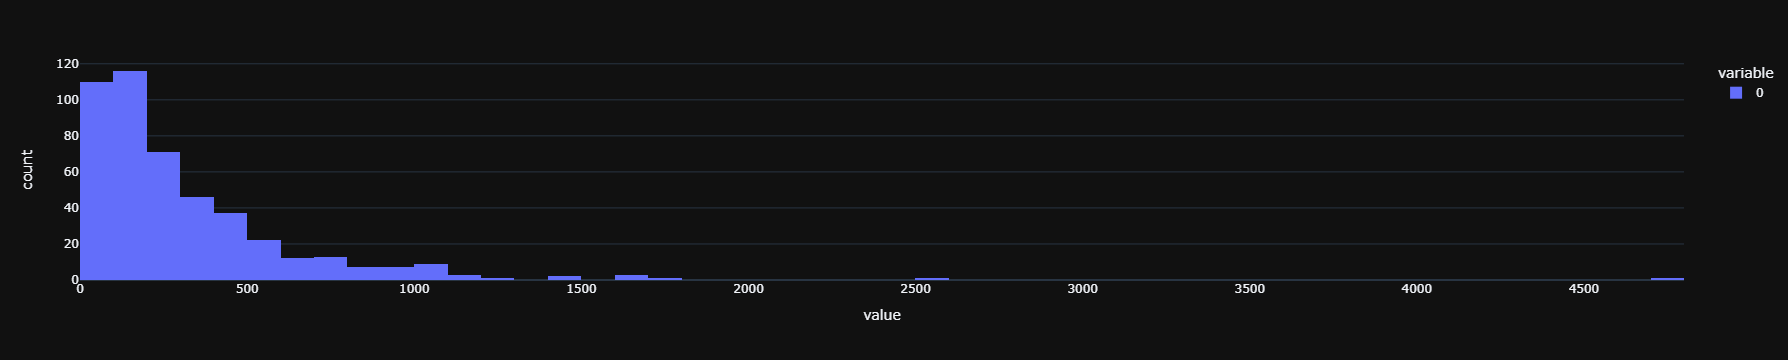

In [92]:
import plotly.express as px

def get_all_code(code_files: dict[str, IgorFile]):
    all_functions = []
    for file in code_files.values():
        all_functions.extend(file.functions)
        all_functions.extend(file.structures)
        all_functions.extend(file.macros)
    return all_functions


all_functions = get_all_code(code_files)
print(f'Total of {len(all_functions)} functions/structures/macros')

px.histogram([token_len(func.code) for func in all_functions], template='plotly_dark')

Let's see whats going on with any super long "functions". 

We don't really want super long functions like this, as they will overload the context of the LLM, and probably won't be very relevant for the most part

In [93]:
for func in all_functions:
    if token_len(func.code) > 2000:
        display(Markdown(func.to_markdown(include_code=False )))

## Summary

- **Name**: test_lakeshore
- **Declaration**: test_lakeshore(ls370,[gets,sets,set_defaults,ask])
- **Start_line**: 1128
- **End_line**: 1547
- **Filename**: ls370_resistancebridge
## Docstring

```
Testing all Lakeshore commands
```


## Summary

- **Name**: ScanController
- **Declaration**: ScanController(v_left,v_right,v_top,v_bottom):Panel
- **Start_line**: 1991
- **End_line**: 2091
- **Filename**: ScanController
## Docstring

```

```


OK, `ScanController` we will keep since that is a pretty core function. `test_lakeshore` we'll just get rid of since that isn't particularly useful anyway.

461


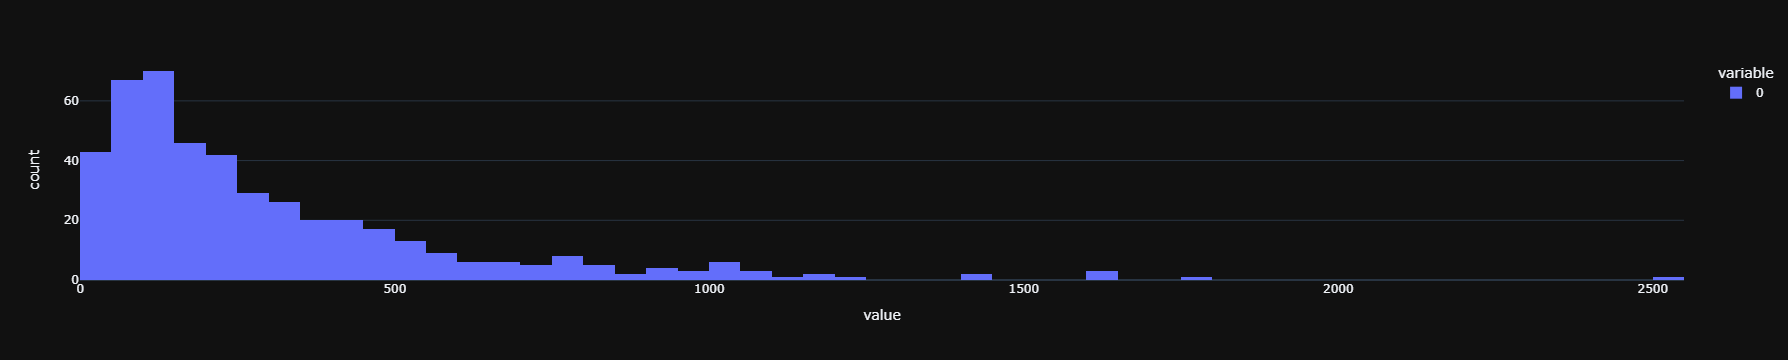

In [94]:
code_file = code_files['ls370_resistancebridge']
code_file.functions = [f for f in code_file.functions if f.name != 'test_lakeshore']
all_functions = get_all_code(code_files)
print(len(all_functions))
px.histogram([token_len(func.code) for func in all_functions], nbins=100, template='plotly_dark')

In [100]:
total_tokens = sum([token_len(f.code) for f in all_functions])
print(f'Total tokens = {total_tokens}\nTotal cost = ${total_tokens/1000*0.0001:.4f}')

Total tokens = 141242
Total cost = $0.0141


# Make Embeddings

Make embeddings for:
- For function_name
- For declaration and docstring
- For full function

TODO: All of these will point to the same documents, so not really necessary to have that saved 3 times, but for now it's so easy and doesn't cost much space


In [101]:
from langchain.embeddings import OpenAIEmbeddings

In [102]:
import numpy  as np

def process_texts(embedder, texts: list[str], batch_size: int) -> np.ndarray:
    """
    Process a list of texts in batches of a given size and apply a function to each batch.

    Args:
        embedder: What will actually do the embedding (assumes from langchain.embbedings)
        texts: A list of texts to be processed.
        batch_size: The size of each batch.
        func: The function to be applied to each batch of texts.

    Returns:
        A list of lists containing the output of `func` for each batch of texts.
    """
    output = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        output.extend(embedder.embed_documents(batch))
    return np.array(output)
        


In [119]:
all_functions = get_all_code(code_files)
metadatas = [f.metadata for f in all_functions]
                             
function_names = [f.name for f in all_functions]
declarations_and_docstrings = ['\n'.join([f.declaration, f.docstring]) for f in all_functions]
full_functions = [f.code for f in all_functions]

all_embedding_texts = [function_names, declarations_and_docstrings, full_functions]

save_names = ['function_name', 'declaration_and_docstring', 'full_function']

In [120]:
total_tokens = sum([token_len(text) for texts in all_embedding_texts for text in texts])
print(f'Total tokens = {total_tokens}\nTotal cost = ${total_tokens/1000*0.0001:.4f}')

Total tokens = 157533
Total cost = $0.0158


In [109]:
from tqdm.auto import tqdm

raise Exception(f'Only remove this raise when you really want to regenerate embeddings')

embedder = OpenAIEmbeddings()
for texts, save_name in tqdm(zip(all_embedding_texts, save_names)):
    embeddings = process_texts(embedder, texts, batch_size=100)
    np.save(save_name+'_embeddings.npy', embeddings)
   

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.72s/it]
1it [00:18, 18.69s/it]
100%|████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.43s/it]
2it [00:30, 14.88s/it]
100%|████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]
3it [00:45, 15.16s/it]


# Use embeddings to create Vectorstore

In [121]:
from langchain.vectorstores import FAISS

for texts, save_name in tqdm(zip(all_embedding_texts, save_names)):
    embeddings = np.load(save_name+'_embeddings.npy')
    text_embeddings = list(zip(texts, embeddings))
    docstore = FAISS.from_embeddings(text_embeddings, embedder, metadatas=metadatas)
    docstore.save_local('faiss_dbs', save_name)

3it [00:00, 48.39it/s]


# Test searching vector DB

In [117]:
def test_query_db(query, index_name):
    docsearch = FAISS.load_local('faiss_dbs', embeddings=embedder, index_name=index_name)
    close_docs = docsearch.similarity_search_with_score(query, k=5)
    print(f'Found {len(close_docs)} docs')
    for doc, score in close_docs:
        print(f'Score: {score}\nMetadata: {doc.metadata}\nContent: \n{doc.page_content}\n\n')

In [122]:
test_query_db('Scan a fastdac', 'function_name')

Found 5 docs
Score: 0.1239592656493187
Metadata: {'name': 'ScanFastDAC', 'declaration': 'ScanFastDAC(instrID,start,fin,channels,[numptsx,sweeprate,delay,ramprate,repeats,alternate,starts,fins,x_label,y_label,comments,nosave,use_awg,interlaced_channels,interlaced_setpoints])', 'start_line': 329, 'end_line': 412, 'filename': 'Scans', 'docstring': '1D repeat scan for FastDAC\nNote: to alternate scan direction set alternate=1\nNote: Ramprate is only for ramping gates between scans'}
Content: 
ScanFastDAC


Score: 0.15115290880203247
Metadata: {'name': 'ScanFastDacSlow', 'declaration': 'ScanFastDacSlow(instrID,start,fin,channels,numpts,delay,ramprate,[starts,fins,y_label,repeats,alternate,delayy,until_checkwave,until_stop_val,until_operator,comments,nosave])//Units:mV', 'start_line': 415, 'end_line': 515, 'filename': 'Scans', 'docstring': 'sweep one or more FastDAC channels but in the ScanController way (not ScanControllerFastdac). I.e. ramp, measure, ramp, measure...\nchannels should be a 

In [124]:
test_query_db('ramp multiple fastdacs at once', 'declaration_and_docstring')
              

Found 5 docs
Score: 0.33729317784309387
Metadata: {'name': 'RampMultipleFDAC', 'declaration': 'RampMultipleFDAC(InstrID,channels,setpoint,[ramprate,setpoints_str,ignore_lims])', 'start_line': 343, 'end_line': 373, 'filename': 'fastdac', 'docstring': 'Ramps multiple channels to setpoint(s) (this is the ramp function that SHOULD be used)\nInstrID - FastDAC connection variable (e.g. fd)\nchannels - comma separated list of channels to sweep\nsetpoint - Value to sweep channels to (ignored if using setpoints_str)\nramprate - sweeprate of channels to setpoint mV/s\nsetpoints_str - comma separated list of setpoints for each channel in channels (setpoint ignored)\nNote: If ramprate is left default, then each channel will ramp at speed specified in FastDAC window'}
Content: 
RampMultipleFDAC(InstrID,channels,setpoint,[ramprate,setpoints_str,ignore_lims])
Ramps multiple channels to setpoint(s) (this is the ramp function that SHOULD be used)
InstrID - FastDAC connection variable (e.g. fd)
channels

In [125]:
test_query_db('Scan at varying temperatures', 'full_function')

Found 5 docs
Score: 0.3566690683364868
Metadata: {'name': 'StepTempScanSomething', 'declaration': 'StepTempScanSomething()', 'start_line': 1762, 'end_line': 1790, 'filename': 'Scans', 'docstring': ''}
Content: 
function StepTempScanSomething()
 svar ls370


	make/o targettemps =  {300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50, 40, 30, 20}
	make/o heaterranges = {10, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 1, 1, 1, 1}
	setLS370exclusivereader(ls370,"mc") 
	variable i=0
	do
		setLS370Temp(ls370,targettemps[i],maxcurrent = heaterranges[i])
		sc_sleep(2.0)
		WaitTillTempStable(ls370, targettemps[i], 5, 20, 0.10)
		sc_sleep(60.0)
		print "MEASURE AT: "+num2str(targettemps[i])+"mK"


		//SCAN HERE

		i+=1
	while ( i<numpnts(targettemps) )

	// kill temperature control
	setLS370heaterOff(ls370)
	
	resetLS370exclusivereader(ls370)
	sc_sleep(60.0*30)

	// 	SCAN HERE for base temp



Score: 0.4161447286605835
Metadata: {'name': 'StepTempScanFunc', 'declaration': 'StepTempScanFunc(sFun

# Optional - Test with a very basic QA Chain

In [50]:
# from langchain.chains.question_answering import load_qa_chain
# from langchain.llms import OpenAI

# llm = OpenAI()
# chain = load_qa_chain(llm, chain_type='stuff')  # Stuff all data in at once (Other methods might work better if more context required)

# chain.llm_chain.prompt.template

# query = "how do I make a 2D graph?"
# qdocs = docsearch.similarity_search(query)
# response = chain.run(input_documents=qdocs, question=query)
# response